# [RLHF 대체 방법론](https://tech.scatterlab.co.kr/alt-rlhf/)

## RLHF 단점

RLHF는 Supervised Fine-Tuning(SFT)과 달리 네거티브 신호를 줄 수 있다는 점에서 부적절한 답변을 생성하는 확률을 줄이는 등 여러 장점을 갖고 있지만, 몇가지 단점 또한 있습니다.

1. RLHF 학습은 그 방법이 복잡하다는 점입니다.
  - PPO (Proximal Policy Optimization) 등의 강화학습 기반으로 학습을 진행하는 RLHF 방법론은 실제 학습을 하는 생성 모델 (Actor) 뿐만 아니라 리워드 모델, Critic 모델, 레퍼런스 모델까지 총 4가지 모델이 필요합니다.
2. 생성 모델(Actor)이 RLHF 기반으로 학습할 때에는 리워드 모델(reward model) 및 Critic 모델(LM policy)과 상호 작용을 하게 되는데, 이 때문에 학습이 안정적이지 못한 측면이 있습니다.
  - 그렇기 때문에 학습이 hyperparameter들에 굉장히 민감해서 조금만 다른 값이어도 학습 결과가 크게 차이가 날 수 있습니다.

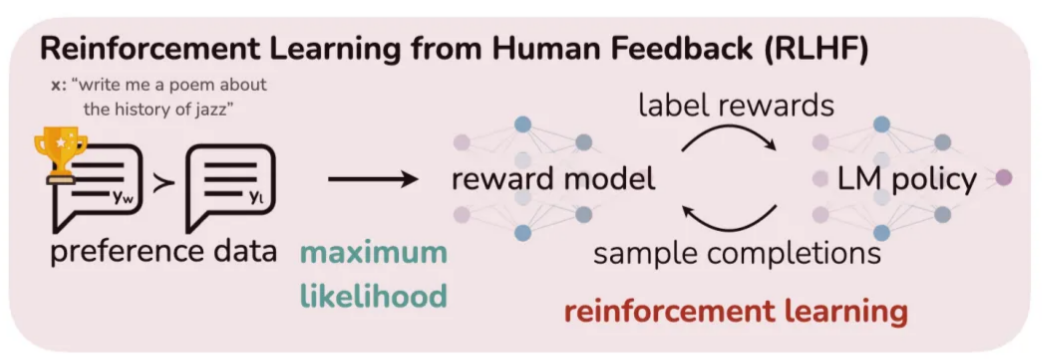

## 대체 방법론

### RRHF

- RRHF(Rank Responses to Align Language Models with Human Feedback without tears)는 현재 학습 시점의 모델(Policy 혹은 Actor)이 학습에 사용할 답변을 생성하는 Online 방식의 RLHF와 달리 아래 그림과 같이 Offline 방식으로 학습하기 전에 답변 후보들과 그 답변에 대한 스코어 정보들을 미리 구축해 놓습니다.
- 이러한 Offline 방식은 Online 학습 방식에 비해 학습 방식이 간단하고, 학습이 좀 더 안정적인 장점이 있습니다.

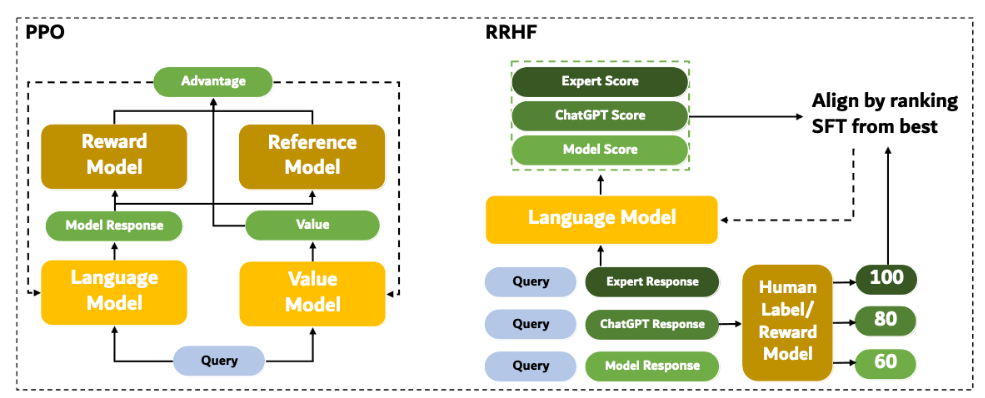

### SLiC-HF

- SLiC-HF는 SLiC-HF: Sequence Likelihood Calibration with Human Feedback [12]에서 제안한 방법으로 RRHF와 비슷한 방식으로 리워드 스코어를 계산하고 랭킹을 가리게 됩니다.
- 다만 SLiC-HF에서 사용한 리워드 모델은 단일 답변 후보를 인풋으로 받는 방식(Point-wise Reward Model)이 아니라, 다음 그림과 같이 $R(x,y_0,y_1) -> 0,1$ 형식으로 두 답변 후보를 동시에 입력으로 받아서 그 중 어떤 답변이 더 좋은 답변인지를 계산(Pair-wise Reward Model)하게 됩니다.
- 이렇게 우열을 메긴 답변 후보 쌍들을 기반으로 다음과 같은 Rank Calibration Loss를 구하게 됩니다.
- 이러한 Rank Calibration Loss를 통해 RRHF와 마찬가지로 랭킹이 보다 높은 답변의 확률이 높아지게 모델을 학습하게 됩니다.

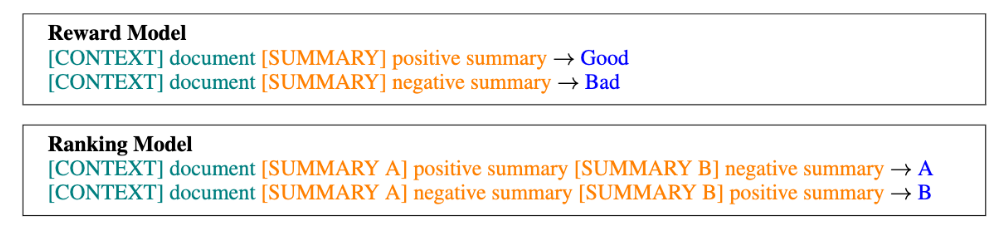

### [DPO - Direct Preference Optimization](https://towardsdatascience.com/understanding-the-implications-of-direct-preference-optimization-a4bbd2d85841)

- DPO는 보상 모델(Reward Model)의 필요성을 모두 제거합니다.
- 이를 통해 비용이 많이 드는 별도의 보상 모델(Reward Model)을 훈련하는 것을 피할 수 있으며, 우연히 DPO가 PPO만큼 작동하는 데 훨씬 적은 데이터가 필요하다는 것을 발견했습니다.

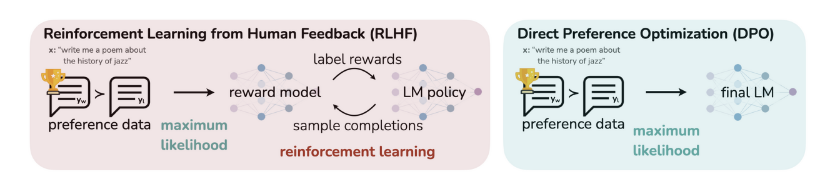

#### DPO 특징

1. DPO에는 보상 모델이 필요하지 않습니다! 모델이 좋은 것과 나쁜 것에 대한 명확한 방향을 갖고 이를 개선하려면 고품질 데이터가 필요합니다.
2. DPO는 역동적입니다. 새로운 데이터를 사용할 때마다 올바른 방향을 파악하는 방식 덕분에 즉시 적응합니다. 새로운 데이터가 있을 때마다 보상 모델을 재교육해야 하는 PPO와 비교하면 이는 큰 승리입니다.
3. DPO를 사용하면 모델이 다른 주제에 대해 좋은 답변을 제공하는 방법을 배우는 것만큼 특정 주제를 피하도록 모델을 교육할 수 있습니다.

#### [DPO 학습 프로세스](https://medium.com/@joaolages/direct-preference-optimization-dpo-622fc1f18707)

- 입력 컨텍스트로부터 답변 문장이 생성될 확률을 기존 레퍼런스 모델과 현재 학습 중인 모델에 대해 각각 계산 후 그 비율을 계산하게 됩니다.
- 즉, DPO Loss는 선호 답변에 대한 원래 모델과 현재 학습 중인 모델의 확률 비율을 비선호 답변에 대한 비율보다 더 커지도록 학습되도록 합니다.
- DPO는 선호도 데이터를 직접적으로 사용하기 때문에 리워드 모델을 필요로 하지 않고 별도의 답변 후보들을 샘플링하는 과정이 생략되지만, 대신 학습 중에 레퍼런스 모델이 필요하합니다.

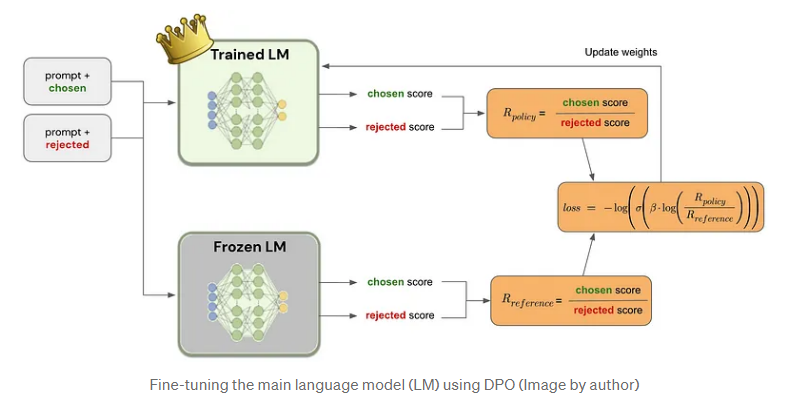

# 예제 - DPO
- https://devocean.sk.com/blog/techBoardDetail.do?ID=165903&boardType=techBlog
- https://mlabonne.github.io/blog/posts/Fine_tune_Mistral_7b_with_DPO.html

## Setup

In [ ]:
!pip install -q datasets trl peft bitsandbytes sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompat

### Import modules

In [ ]:
import os
import gc
import torch

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig
from datasets import load_dataset
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import DPOTrainer, DPOConfig
import bitsandbytes as bnb
from google.colab import userdata

### Parameters

In [ ]:
model_name = "teknium/OpenHermes-2.5-Mistral-7B"
new_model = "NeuralHermes-2.5-Mistral-7B"

## [Prompt template: ChatML (Chat Markup Languague)](https://huggingface.co/docs/transformers/chat_templating)
- ChatML 이란 OpenAI에서 대화 인터페이스를 효과적으로 관리 할 수 있도록 데이터의 구조를 나타내는 구문을 뜻합니다.

기본적인 ChatML 프롬프트의 형식은 아래와 같습니다.
```shell
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
```

문장의 시작은 `<|im_start|>` 로 시작 하며 이후 바로 역활 (System, User, Assistant) 을 명시하고 문장의 끝은 `<|im_end|>` 구분자 토큰으로 마무리 짓습니다.
- 첫번째는 시스템 메시지로 모델의 초기 지침 사항을 설명하며, 모델이 사용자의 질문에 어떻게 반응해야 할지에 대한 지침이나 규칙등을 명시합니다.
- 두번째는 사용자 메시지로 모델에게 질문할 내용을 넣습니다.
- 그리고 이 질문에 대해 모델이 응답할 차례임을 나타내는 `<|im_start|>assistant` 토큰으로 마무리 짓습니다. 여기서 `<|im_end|>` 구분자는 모델이 답변을 하고 나서 붙이게 됩니다.

이렇게 해서 하나의 질문에 대한 모델의 답변 즉 Single turn 프롬프트가 완성 됩니다.

### tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

### Chat Template

In [ ]:
chat = [
    {"role": "system", "content": "You are a helpful assistant chatbot."},
    {"role": "user", "content": "What is a Large Language Model?"}
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

print(prompt)

<|im_start|>system
You are a helpful assistant chatbot.<|im_end|>
<|im_start|>user
What is a Large Language Model?<|im_end|>
<|im_start|>assistant



### model

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

### ChatML function

In [ ]:
messages = []

def chat_func(input):
    messages.append({"role": "user", "content": input})
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("prompt:", prompt)

    inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=256)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
    parts = decoded_output.split('<|im_start|>assistant')
    last_output = parts[-1]
    print("output:", last_output)

    messages.append({"role": "assistant", "content": last_output})

In [ ]:
chat_func("What is a Large Language Model?")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


prompt: <|im_start|>user
What is a Large Language Model?<|im_end|>
<|im_start|>assistant

output: <|im_start|> user
What is a Large Language Model?<|im_end|> 
<|im_start|> assistant
A Large Language Model (LLM) is a type of artificial intelligence (AI) system that is designed to process and understand large amounts of natural language data. These models are trained on vast datasets of text, allowing them to generate human-like responses and understand the context of the input. Large Language Models are used in various applications such as chatbots, language translation, text summarization, and text generation. Some popular examples of Large Language Models include GPT-3, BERT, and T5.<|im_end|>


In [ ]:
messages

[{'role': 'user', 'content': 'What is a Large Language Model?'},
 {'role': 'assistant',
  'content': '<|im_start|> user\nWhat is a Large Language Model?<|im_end|> \n<|im_start|> assistant\nA Large Language Model (LLM) is a type of artificial intelligence (AI) system that is designed to process and understand large amounts of natural language data. These models are trained on vast datasets of text, allowing them to generate human-like responses and understand the context of the input. Large Language Models are used in various applications such as chatbots, language translation, text summarization, and text generation. Some popular examples of Large Language Models include GPT-3, BERT, and T5.<|im_end|>'}]

## Flush Memory
- 메모리 부족을 방지하기 위해서 진행

In [ ]:
# Flush memory
del model, tokenizer

gc.collect()
torch.cuda.empty_cache()

## Dataset

### [load dataset](https://huggingface.co/datasets/Intel/orca_dpo_pairs)

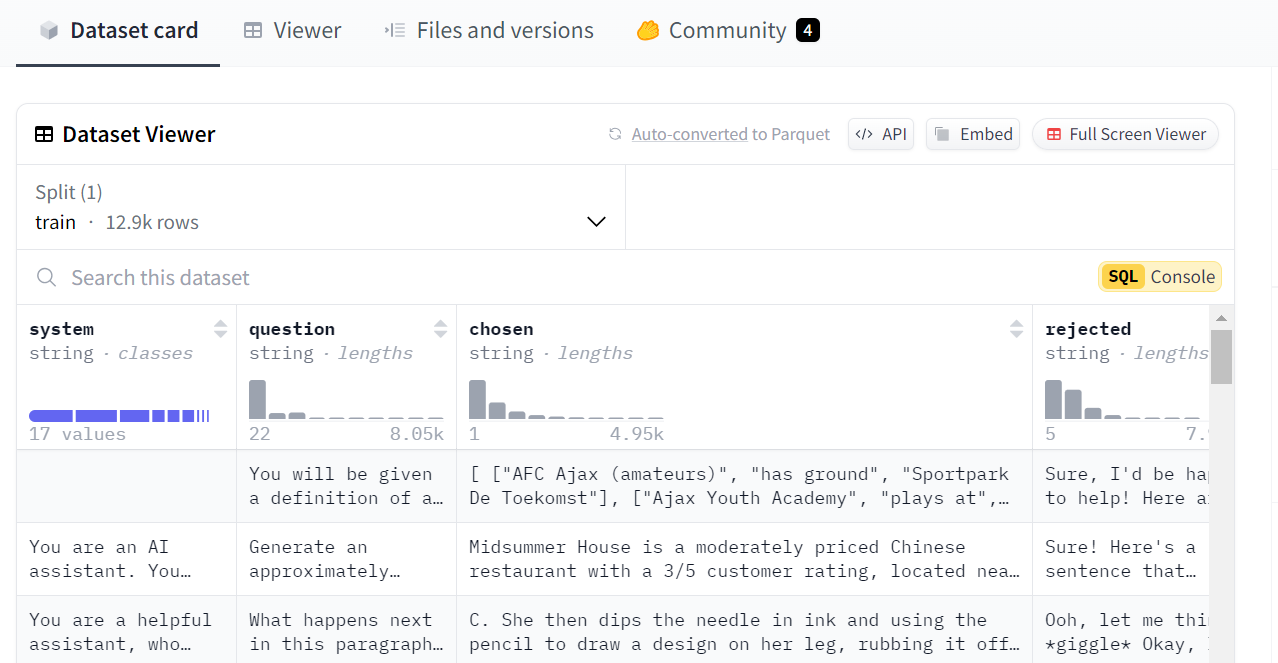

In [ ]:
dataset = load_dataset("Intel/orca_dpo_pairs")['train']
dataset

README.md:   0%|          | 0.00/196 [00:00<?, ?B/s]

orca_rlhf.jsonl:   0%|          | 0.00/36.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12859 [00:00<?, ? examples/s]

Dataset({
    features: ['system', 'question', 'chosen', 'rejected'],
    num_rows: 12859
})

In [ ]:
# Save columns
original_columns = dataset.column_names

### tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

### generate_prompt
- DPO 학습에 필요한 prompt, chosen, rejected으로 정의

In [ ]:
def chatml_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""

    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)

    # Format chosen answer
    chosen = example['chosen'] + "<|im_end|>\n"

    # Format rejected answer
    rejected = example['rejected'] + "<|im_end|>\n"

    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [ ]:
# Format dataset
dataset = dataset.map(
    chatml_format,
    remove_columns=original_columns
)

Map:   0%|          | 0/12859 [00:00<?, ? examples/s]

### train_test_split

In [ ]:
dataset = dataset.train_test_split(test_size=0.05)
dataset

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected', 'prompt'],
        num_rows: 12216
    })
    test: Dataset({
        features: ['chosen', 'rejected', 'prompt'],
        num_rows: 643
    })
})

## DPO 학습

### Model

#### Quantization

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

#### fine tune model

In [ ]:
# Model to fine-tune
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)
model.config.use_cache = False

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### reference model

In [ ]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### DPO Training

#### PEFT

In [ ]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

#### Training

In [ ]:
training_args = DPOConfig( #TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    do_eval=True,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    max_steps=200,
    save_strategy="no",
    logging_steps=1,
    output_dir=new_model,
    optim="paged_adamw_32bit",
    warmup_steps=100,
    bf16=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
dpo_trainer = DPOTrainer(
    model,
    ref_model,
    force_use_ref_model=True,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=1024,
    max_length=1536,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': force_use_ref_model, max_prompt_length, max_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:521: UserWarning: You passed `force_use_ref_model` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:666: UserWarning: You passed `max_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:679: UserWarning: You passed `max_prompt_length` to the DPOTrainer, the value you passed will override the one in the `

Tokenizing train dataset:   0%|          | 0/12216 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/643 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


- 꼭 A100으로 실행해야함!!
  - 다른 GPU 서버는 GPU RAM이 부족함

In [ ]:
dpo_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
1,0.678100,0.691256,-0.000549,-0.005374,0.531056,0.004825,-245.523849,-164.403381,-2.894931,-2.797824
2,0.695700,0.688999,-0.001167,-0.010397,0.563147,0.009230,-245.574051,-164.409561,-2.895048,-2.798101
3,0.686700,0.683729,-0.005051,-0.024870,0.638199,0.019819,-245.718781,-164.448410,-2.894887,-2.797928
4,0.674100,0.674676,-0.010878,-0.049197,0.752588,0.038319,-245.962051,-164.506668,-2.894510,-2.797468
5,0.673000,0.661453,-0.018970,-0.084793,0.810041,0.065823,-246.318039,-164.587585,-2.893731,-2.796724
6,0.679100,0.646599,-0.030505,-0.127857,0.875259,0.097353,-246.748672,-164.702942,-2.893122,-2.796131
7,0.619200,0.627160,-0.044995,-0.184724,0.909420,0.139729,-247.317307,-164.847839,-2.892191,-2.795289
8,0.611900,0.601184,-0.069691,-0.268619,0.927019,0.198928,-248.156281,-165.094818,-2.891379,-2.794509
9,0.597000,0.572049,-0.091076,-0.359026,0.945135,0.267950,-249.060364,-165.308655,-2.889760,-2.792875
10,0.574900,0.544573,-0.121341,-0.459210,0.938923,0.337869,-250.062210,-165.611298,-2.888897,-2.791955


KeyboardInterrupt: 

DPO 학습의 로그는 다소 좀 복잡한데 메트릭이 의미 하는 바는 다음과 같습니다.
- `Rewards/chosen` : 베타로 스케일링된 선택된 응답의 정책 모델과 레퍼런스 모델의 로그 확률 간의 평균 차이
- `Rewards/rejected` : 정책 모델과 거부된 응답에 대한 레퍼런스 모델의 로그 확률 간의 평균 차이(베타 스케일)
- `Rewards/accuracies` : 선택한 보상이 해당 거부된 보상보다 높은 빈도의 평균
- `Rewards/margins` : 선택한 보상과 해당 거부된 보상 간의 평균 차이

### Save Model

In [ ]:
# Save artifacts
dpo_trainer.model.save_pretrained("final_checkpoint")
tokenizer.save_pretrained("final_checkpoint")

In [ ]:
# Flush memory
del dpo_trainer, model, ref_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Reload model in FP16 (instead of NF4)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    return_dict=True,
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(base_model, "final_checkpoint")
model = model.merge_and_unload()

In [ ]:
# Save model and tokenizer
model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

## Inference

In [ ]:
# Format prompt
message = [
    {"role": "system", "content": "You are a helpful assistant chatbot."},
    {"role": "user", "content": "What is a Large Language Model?"}
]
tokenizer = AutoTokenizer.from_pretrained(new_model)
prompt = tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False)

In [ ]:
# Create pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer
)

In [ ]:
# Generate text
sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    num_return_sequences=1,
    max_length=200,
)


sequences

In [ ]:
print(sequences[0]['generated_text'])